<img src="NotebookAddons/blackboard-banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing <b> </font>

<font size="5"> <b>Lab 7: Deep Learning in Earth Observation: Taizhou Change Detection </b> </font>

<br>
<font size="4"> <b> Lichao Mou, German Aerospace Center; Xiaoxiang Zhu, German Aerospace Center & Technical University Munich </b> <br>
</font>

<img src="NotebookAddons/dlr-logo-png-transparent.png" width="170" align="right" border="2"/> <font size="3"> This Lab introduces you to the basic concepts of Deep Learning in Earth Observation. Specifically, it uses Convolutional Recurrent Neural Networks (CRNNs) to perform a multi-temporal change detection on multispectral data collected over Taizhou, China. The images are both 400 × 400 pixels in size and show significant changes mainly related to city expansion, soil change, and varying water areas.
    
We will again use a **Jupyter Notebook** framework implemented within the Amazon Web Services (AWS) cloud to work on this exercise. This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. It will introduce the following data analysis concepts:

- How to set up a convolutional recurrent deep network within the Python-based <i>keras/tensorflow</i> environment
- How to use CRNNs to perform change detection on multi-temporal remote sensing data 
</font>

<font size="4"> <font color='rgba(200,0,0,0.2)'> <b>There are no Homework assignments associated with this Notebook </b> </font>
</font>
<br>
<hr>

<hr>
<font face="Calibri" size="5" color="red"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Nadam
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers import Conv2D, Reshape, Activation, Concatenate, GRU, Dense, LSTM, SimpleRNN


Using TensorFlow backend.


<hr>
<font face="Calibri" size="5"> <b> Step 1: Data Preparation </b> </font> 

<font size="3"><b>load T1 and T2 images, training map, and test map:</b></font> 

########## load data... ##########
the shape of T1 image is: (402, 402, 6)
the shape of T2 image is: (402, 402, 6)


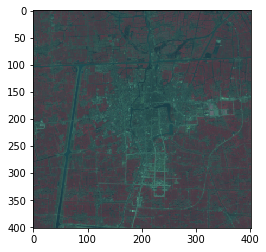

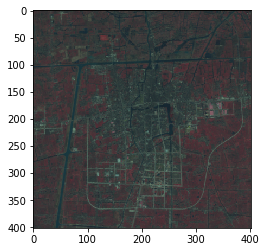

the shape of input tensors on training set is: (1000, 3, 3, 6)
the shape of target tensor on training set is: (1000,)
the shape of input tensors on training set is: (21016, 3, 3, 6)
the shape of target tensor on training set is: (21016,)


In [2]:
patch_size = 3
num_bands = 6
print('########## load data... ##########')
data = sio.loadmat('DL-data/Taizhou_3x3/TaizhouTm2000_norm.mat')
imgT1 = np.float32(data['imgT1'])
data = sio.loadmat('DL-data/Taizhou_3x3/TaizhouTm2003_norm.mat')
imgT2 = np.float32(data['imgT2'])

data = sio.loadmat('DL-data/Taizhou_3x3/TaizhouTraMapBinary.mat')
tra_map = np.uint8(data['tra_map_binary'])
data = sio.loadmat('DL-data/Taizhou_3x3/TaizhouTestMapBinary.mat')
test_map = np.uint8(data['test_map_binary'])

print('the shape of T1 image is: {}'.format(imgT1.shape))
print('the shape of T2 image is: {}'.format(imgT2.shape))

plt.imshow(imgT1[:, :, [3, 2, 1]])
plt.show()

plt.imshow(imgT2[:, :, [3, 2, 1]])
plt.show()

[rows, cols] = np.nonzero(tra_map)
num_samples = len(rows)
rows = np.reshape(rows, (num_samples, 1))
cols = np.reshape(cols, (num_samples, 1))
temp = np.concatenate((rows, cols), axis=1)
np.random.shuffle(temp)
rows = temp[:, 0].reshape((num_samples,))
cols = temp[:, 1].reshape((num_samples,))

# sampling 3x3 patches as training samples according to the training map
# training samples from T1 image
x_tra_t1 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))
# training samples from T2 image
x_tra_t2 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))
# ground truths for training samples
y_tra = np.uint8(np.zeros([num_samples, ]))
for i in range(num_samples):
    patch = imgT1[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_tra_t1[i, :, :, :] = patch
    patch = imgT2[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_tra_t2[i, :, :, :] = patch
    y_tra[i] = tra_map[rows[i], cols[i]]-1

[rows, cols] = np.nonzero(test_map)
num_samples = len(rows)
rows = np.reshape(rows, (num_samples, 1))
cols = np.reshape(cols, (num_samples, 1))
temp = np.concatenate((rows, cols), axis=1)
np.random.shuffle(temp)
rows = temp[:, 0].reshape((num_samples,))
cols = temp[:, 1].reshape((num_samples,))

# sampling 3x3 patches as test samples according to the test map
# test samples from T1 image
x_test_t1 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))
# test samples from T2 image
x_test_t2 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))
y_test = np.uint8(np.zeros([num_samples, ]))  # ground truths for test samples
for i in range(num_samples):
    patch = imgT1[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_test_t1[i, :, :, :] = patch
    patch = imgT2[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_test_t2[i, :, :, :] = patch
    y_test[i] = test_map[rows[i], cols[i]]-1

print('the shape of input tensors on training set is: {}'.format(x_tra_t1.shape))
print('the shape of target tensor on training set is: {}'.format(y_tra.shape))
print('the shape of input tensors on training set is: {}'.format(x_test_t1.shape))
print('the shape of target tensor on training set is: {}'.format(y_test.shape))

<hr>
<font face="Calibri" size="5"> <b> Step 2: Building up the recurrent convolutional network </b> </font> 

<font size="3"><b>Write a function to build the network:</b></font> 

In [3]:
def build_network():
    # the T1 branch of the convolutional sub-network
    input1 = Input(shape=(3, 3, 6))
    x1 = Conv2D(filters=32, kernel_size=3, strides=1, padding='valid')(input1)
    x1 = Activation('relu')(x1)
    x1 = Reshape(target_shape=(1, 32))(x1)

    # the T2 branch of the convolutional sub-network
    input2 = Input(shape=(3, 3, 6))
    x2 = Conv2D(filters=32, kernel_size=3, strides=1, padding='valid')(input2)
    x2 = Activation('relu')(x2)
    x2 = Reshape(target_shape=(1, 32))(x2)

    # the recurrent sub-network
    x = Concatenate(axis=1)([x1, x2])
    #x = SimpleRNN(units = 128)(x)
    x = LSTM(units=128)(x)
    #x = GRU(units = 128)(x)
    x = Dense(units=32, activation='relu')(x)
    y = Dense(units=1, activation='sigmoid')(x)

    net = Model(inputs=[input1, input2], outputs=y)

    net.summary()

    return net


<hr>
<font face="Calibri" size="5"> <b> Step 3: Network training </b> </font> 

<font size="3"><b>Build the network:</b></font> 

In [4]:
print('########## train the network... ##########')
batch_size = 32
nb_epoch = 200
net = build_network()

########## train the network... ##########
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 3, 6)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3, 3, 6)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 1, 32)     1760        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 1, 32)     1760        input_2[0][0]               

<font size="3"><b>Train the network:</b></font> 

Instructions for updating:
Use tf.cast instead.
Train on 900 samples, validate on 100 samples
Epoch 1/200
900/900 [==============================] - 1s 912us/step - loss: 0.6935 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/200
900/900 [==============================] - 0s 115us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/200
900/900 [==============================] - 0s 114us/step - loss: 0.6929 - acc: 0.5011 - val_loss: 0.6927 - val_acc: 0.5200
Epoch 4/200
900/900 [==============================] - 0s 114us/step - loss: 0.6927 - acc: 0.6878 - val_loss: 0.6924 - val_acc: 0.7900
Epoch 5/200
900/900 [==============================] - 0s 114us/step - loss: 0.6924 - acc: 0.7544 - val_loss: 0.6922 - val_acc: 0.6200
Epoch 6/200
900/900 [==============================] - 0s 115us/step - loss: 0.6921 - acc: 0.5144 - val_loss: 0.6919 - val_acc: 0.4900
Epoch 7/200
900/900 [==============================] - 0s 119us/step - loss: 0.6919 - acc: 0.487

900/900 [==============================] - 0s 116us/step - loss: 0.6576 - acc: 0.5833 - val_loss: 0.6572 - val_acc: 0.5700
Epoch 60/200
900/900 [==============================] - 0s 115us/step - loss: 0.6559 - acc: 0.6233 - val_loss: 0.6553 - val_acc: 0.5800
Epoch 61/200
900/900 [==============================] - 0s 115us/step - loss: 0.6540 - acc: 0.6011 - val_loss: 0.6535 - val_acc: 0.5900
Epoch 62/200
900/900 [==============================] - 0s 117us/step - loss: 0.6522 - acc: 0.6189 - val_loss: 0.6516 - val_acc: 0.6300
Epoch 63/200
900/900 [==============================] - 0s 114us/step - loss: 0.6501 - acc: 0.6689 - val_loss: 0.6496 - val_acc: 0.6300
Epoch 64/200
900/900 [==============================] - 0s 124us/step - loss: 0.6480 - acc: 0.6756 - val_loss: 0.6475 - val_acc: 0.6700
Epoch 65/200
900/900 [==============================] - 0s 114us/step - loss: 0.6459 - acc: 0.6944 - val_loss: 0.6453 - val_acc: 0.6800
Epoch 66/200
900/900 [==============================] - 0s 11

900/900 [==============================] - 0s 114us/step - loss: 0.4265 - acc: 0.8889 - val_loss: 0.4233 - val_acc: 0.9200
Epoch 120/200
900/900 [==============================] - 0s 115us/step - loss: 0.4232 - acc: 0.8911 - val_loss: 0.4209 - val_acc: 0.9300
Epoch 121/200
900/900 [==============================] - 0s 123us/step - loss: 0.4202 - acc: 0.8900 - val_loss: 0.4170 - val_acc: 0.9200
Epoch 122/200
900/900 [==============================] - 0s 115us/step - loss: 0.4174 - acc: 0.8889 - val_loss: 0.4149 - val_acc: 0.9300
Epoch 123/200
900/900 [==============================] - 0s 117us/step - loss: 0.4146 - acc: 0.8900 - val_loss: 0.4111 - val_acc: 0.9200
Epoch 124/200
900/900 [==============================] - 0s 114us/step - loss: 0.4112 - acc: 0.8933 - val_loss: 0.4079 - val_acc: 0.9300
Epoch 125/200
900/900 [==============================] - 0s 113us/step - loss: 0.4082 - acc: 0.8900 - val_loss: 0.4050 - val_acc: 0.9300
Epoch 126/200
900/900 [==============================] 

Epoch 179/200
900/900 [==============================] - 0s 117us/step - loss: 0.3362 - acc: 0.8956 - val_loss: 0.3304 - val_acc: 0.9300
Epoch 180/200
900/900 [==============================] - 0s 115us/step - loss: 0.3355 - acc: 0.8956 - val_loss: 0.3300 - val_acc: 0.9300
Epoch 181/200
900/900 [==============================] - 0s 115us/step - loss: 0.3350 - acc: 0.8944 - val_loss: 0.3295 - val_acc: 0.9300
Epoch 182/200
900/900 [==============================] - 0s 115us/step - loss: 0.3342 - acc: 0.8956 - val_loss: 0.3276 - val_acc: 0.9300
Epoch 183/200
900/900 [==============================] - 0s 115us/step - loss: 0.3336 - acc: 0.8967 - val_loss: 0.3280 - val_acc: 0.9300
Epoch 184/200
900/900 [==============================] - 0s 114us/step - loss: 0.3329 - acc: 0.8956 - val_loss: 0.3272 - val_acc: 0.9300
Epoch 185/200
900/900 [==============================] - 0s 114us/step - loss: 0.3324 - acc: 0.8944 - val_loss: 0.3286 - val_acc: 0.9300
Epoch 186/200
900/900 [==================

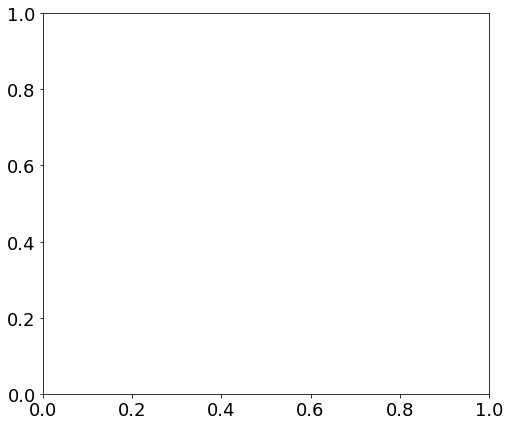

In [5]:
nadam = Nadam(lr=0.00002)
net.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
net_info = net.fit([x_tra_t1, x_tra_t2], y_tra,
                   batch_size=batch_size, validation_split=0.1, epochs=nb_epoch)

loss = net_info.history['loss']
loss_val = net_info.history['val_loss']
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)

<font size="3"><b>Plot the results:</b></font> 

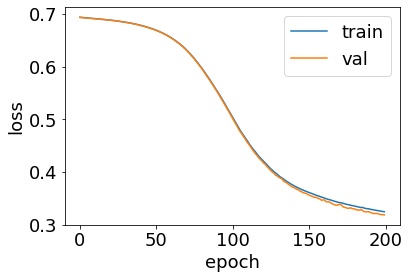

In [6]:
plt.plot(loss)
plt.plot(loss_val)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
#sio.savemat('loss_curves.mat', {'loss': loss, 'loss_val': loss_val})

<hr>
<font face="Calibri" size="5"> <b> Step 4: Test </b> </font> 

<font size="3"><b>Run the network on the test dataset:</b></font> 

########## test... ##########
21016/21016 [==============================] - 1s 32us/step
0.9608869432813095
########## running on the whole image... ##########
sampling patches...
sampling done.


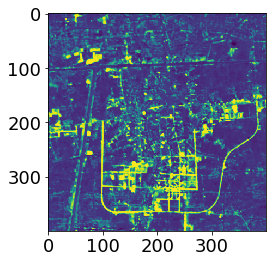

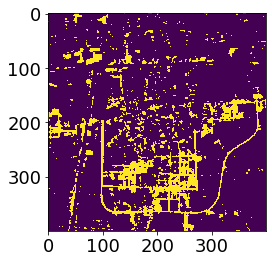

In [7]:
print('########## test... ##########')
# testing on test set
score = net.evaluate([x_test_t1, x_test_t2], y_test)
print(score[1])

print('########## running on the whole image... ##########')
cnt = 0
x_t1 = np.float32(np.zeros([400*400, patch_size, patch_size, num_bands]))
x_t2 = np.float32(np.zeros([400*400, patch_size, patch_size, num_bands]))
print('sampling patches...')
for i in range(1, imgT1.shape[0]-1, 1):
    for j in range(1, imgT1.shape[1]-1, 1):
        patch = imgT1[i-int((patch_size-1)/2): i+int((patch_size-1)/2)+1,
                      j-int((patch_size-1)/2): j+int((patch_size-1)/2)+1, :]
        x_t1[cnt, :, :, :] = patch
        patch = imgT2[i-int((patch_size-1)/2): i+int((patch_size-1)/2)+1,
                      j-int((patch_size-1)/2): j+int((patch_size-1)/2)+1, :]
        x_t2[cnt, :, :, :] = patch
        cnt = cnt + 1
print('sampling done.')
pred = net.predict([x_t1, x_t2])
change_map_prob = np.reshape(pred, (400, 400))
plt.imshow(change_map_prob)
plt.show()

change_map_binary = np.where(change_map_prob < 0.5, 0, 1)
plt.imshow(change_map_binary)
plt.show()
